In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import random

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [33]:
# Define the directories
train_dir = 'fire_data/train'      # Replace with your train directory
valid_dir = 'fire_data/valid' # Replace with your validation directory
test_dir = 'fire_data/test'        # Replace with your test directory

In [34]:
def display_random_sample(dataset_dir):
    classes = [
        class_name for class_name in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, class_name))  # Skip non-directories
    ]
    plt.figure(figsize=(15, 10))  # Adjust the figure size if needed

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        
        # Get valid image files in the class folder
        image_files = [
            file_name for file_name in os.listdir(class_dir)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))  # Filter valid image formats
        ]
        
        if not image_files:
            print(f"No valid images found in class '{class_name}', skipping.")
            continue  # Skip if no valid images in the folder

        # Select a random image
        random_image = random.choice(image_files)
        img_path = os.path.join(class_dir, random_image)
        
        # Load the image
        img = load_img(img_path)
        
        # Display the image
        plt.subplot(1, len(classes), i + 1)  # Display images in a single row
        plt.imshow(img)
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")  # Show class name and image size

    plt.show()

Training set samples:


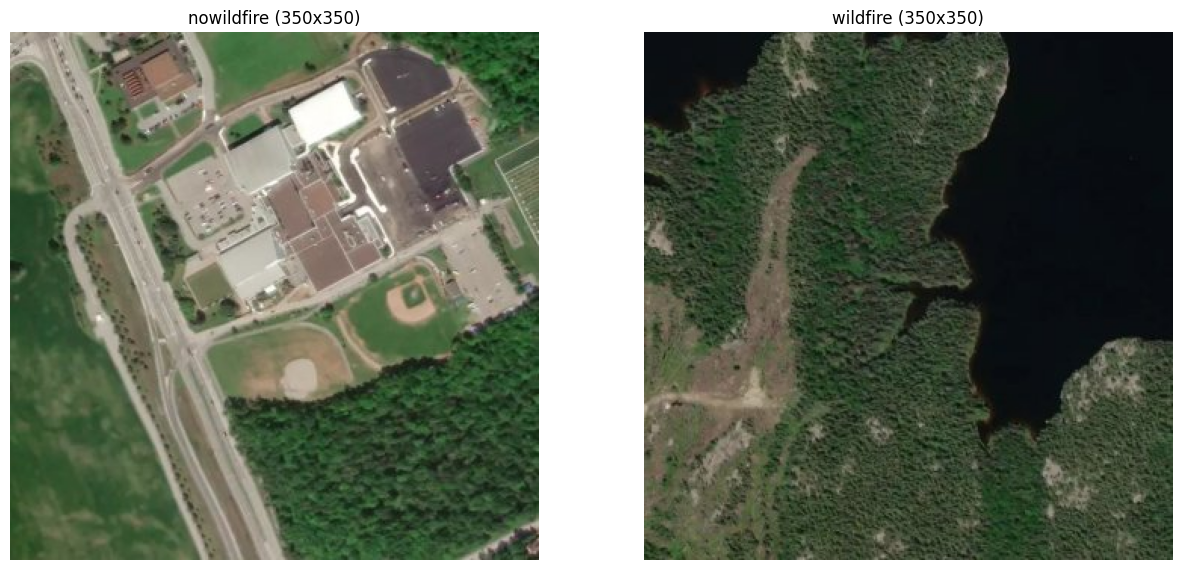

Validation set samples:


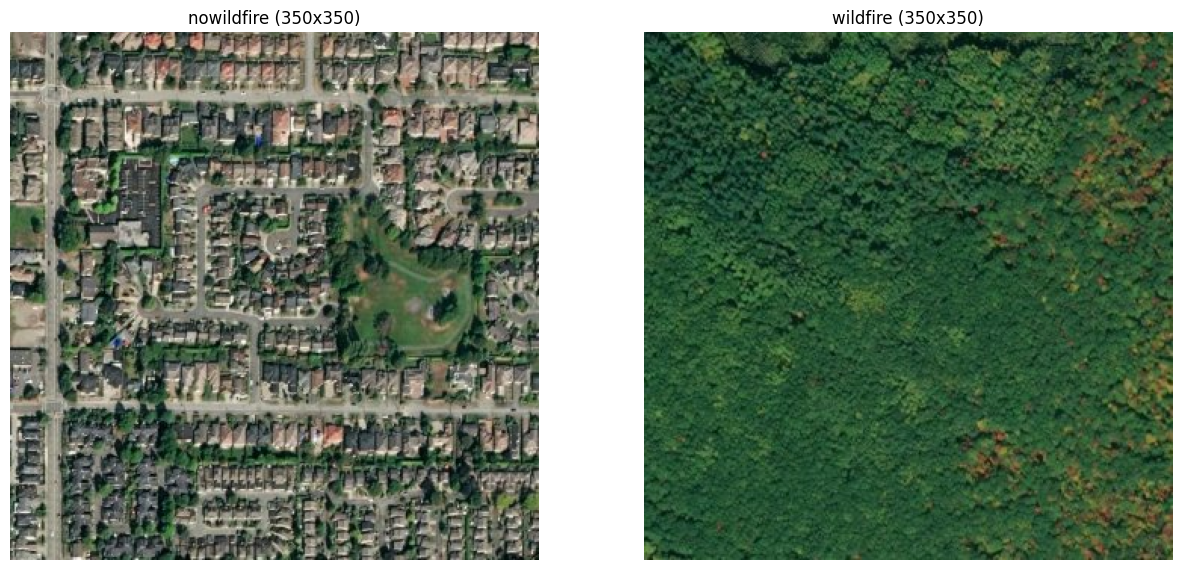

Test set samples:


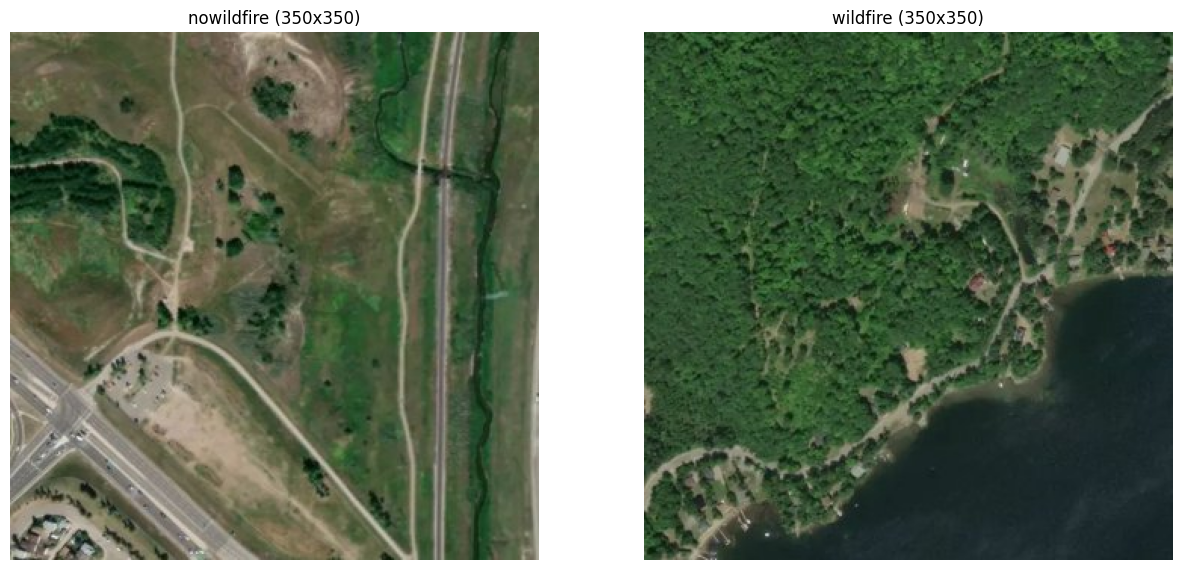

In [35]:
# Display one random sample from train, validation, and test sets
print("Training set samples:")
display_random_sample(train_dir)

print("Validation set samples:")
display_random_sample(valid_dir)

print("Test set samples:")
display_random_sample(test_dir)

In [36]:
dir = 'fire_data/train'

x_train = []
y_train = []

for direct in os.listdir(dir):
    direct_path = os.path.join(dir, direct)
    if not os.path.isdir(direct_path):  # Skip if not a directory
        continue
    print("Loading dataset training {}".format(direct))
    for filename in os.listdir(direct_path):
        img_path = os.path.join(direct_path, filename)
        img = cv2.imread(img_path)
        if img is not None:  # Ensure the image is read successfully
            img = cv2.resize(img, (32, 32))
            img = np.array(img)
            img = img / 255.0  # Normalize pixel values
            x_train.append(img)
            y_train.append(direct)

Loading dataset training nowildfire


Premature end of JPEG file


Loading dataset training wildfire


In [37]:
dir_val = 'fire_data/valid'

x_val = []
y_val = []

for direct in os.listdir(dir_val):
    direct_path = os.path.join(dir_val, direct)
    if not os.path.isdir(direct_path):  # Skip non-directory entries
        continue
    print("Loading dataset validation {}".format(direct))
    for filename in os.listdir(direct_path):
        img_path = os.path.join(direct_path, filename)
        image = cv2.imread(img_path)
        if image is not None:  # Ensure the image is read successfully
            image = cv2.resize(image, (32, 32))
            image = np.array(image)
            image = image / 255.0  # Normalize pixel values
            x_val.append(image)
            y_val.append(direct)

Loading dataset validation nowildfire
Loading dataset validation wildfire


In [38]:
x_test = []
y_test = []

for direct in os.listdir(dir_test):
    direct_path = os.path.join(dir_test, direct)
    if not os.path.isdir(direct_path):  # Skip non-directory entries
        continue
    print("Loading dataset test {}".format(direct))
    for filename in os.listdir(direct_path):
        img_path = os.path.join(direct_path, filename)
        image = cv2.imread(img_path)
        if image is not None:  # Ensure the image is read successfully
            image = cv2.resize(image, (32, 32))
            image = np.array(image)
            image = image / 255.0  # Normalize pixel values
            x_test.append(image)
            y_test.append(direct)

Loading dataset test nowildfire
Loading dataset test wildfire


Premature end of JPEG file


In [39]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [40]:
y_train[30000]

'wildfire'

In [41]:
# Replace "wildfire" with 1 and "nowildfire" with 0
y_train = [1 if label == 'wildfire' else 0 for label in y_train]
y_val = [1 if label == 'wildfire' else 0 for label in y_val]
y_test = [1 if label == 'wildfire' else 0 for label in y_test]

In [42]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [43]:
len(x_train[4][4])

32

In [44]:
# Now check the shape of your datasets
print("x_train shape:", x_train.shape)  # Should be (num_samples, height, width, num_channels)
print("x_valid shape:", x_val.shape)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_valid shape:", y_val.shape)
print("y_test shape:", y_test.shape)

x_train shape: (30250, 32, 32, 3)
x_valid shape: (6300, 32, 32, 3)
x_test shape: (6300, 32, 32, 3)
y_train shape: (30250,)
y_valid shape: (6300,)
y_test shape: (6300,)


In [45]:
# Step 1: Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')  # Output layer with number of classes
])

# Step 2: Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           12

 Total params: 1,782,529 (6.80 MB)

 Trainable params: 1,781,313 (6.80 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# Step 3: Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 159s 332ms/step - accuracy: 0.8915 - loss: 0.2749 - val_accuracy: 0.6722 - val_loss: 0.6295
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 173s 365ms/step - accuracy: 0.9272 - loss: 0.1885 - val_accuracy: 0.8800 - val_loss: 0.3133
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 178s 376ms/step - accuracy: 0.9356 - loss: 0.1672 - val_accuracy: 0.7625 - val_loss: 0.4986
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 193s 409ms/step - accuracy: 0.9393 - loss: 0.1582 - val_accuracy: 0.8614 - val_loss: 0.3374
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 189s 401ms/step - accuracy: 0.9463 - loss: 0.1414 - val_accuracy: 0.9248 - val_loss: 0.1967
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 220s 465ms/step - accuracy: 0.9478 - loss: 0.1433 - val_accuracy: 0.9137 - val_loss: 0.2159
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 245s 518ms/step - accuracy: 0.9523 - loss: 0.1275 - val_accuracy: 0.9392 - val_loss: 0.1574
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 249s 526ms/step - accuracy: 0.9560 -

In [47]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')

197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9619 - loss: 0.1082
Test Accuracy: 0.9519


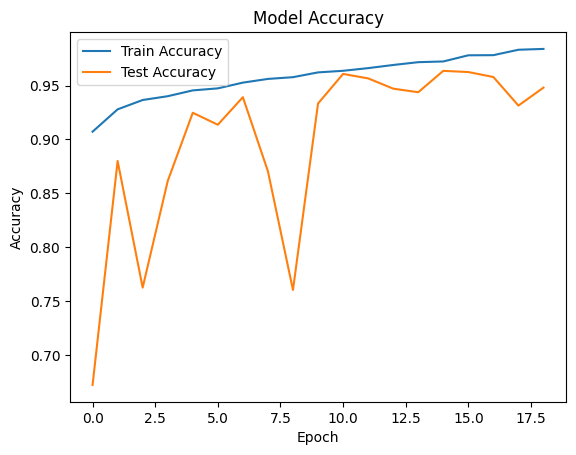

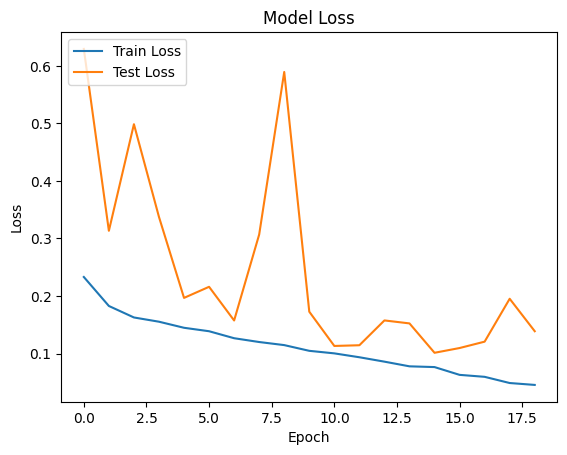

In [48]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:

# Predict on the datasets
y_test_pred = model.predict(x_test)

# Convert probabilities to binary classes if using a classification model
y_test_pred_classes = (y_test_pred > 0.5).astype("int32")



946/946 ━━━━━━━━━━━━━━━━━━━━ 103s 109ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step


Confusion matrix for test: 



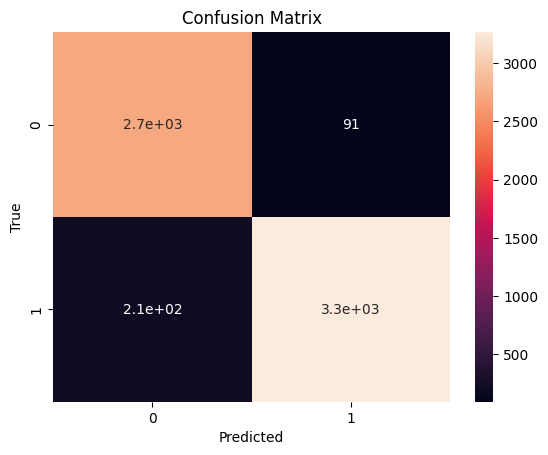

In [54]:
print("Confusion matrix for test: \n")
cm = confusion_matrix(y_test, y_test_pred_classes)
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [55]:
print(f"classification report for test : \n{classification_report(y_test, y_test_pred_classes)}")

classification report for test : 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2820
           1       0.97      0.94      0.96      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300

